In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import pretty inbuilt print
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [64]:
from src.prep import Prep
prep = Prep()

OPTICS - car.csv

In [42]:
hyprparam_grid = {
    "min_samples": [30, 40, 50, 60],
    "max_eps": [3, 4, 5, np.inf],
    "metric": ['manhattan', 'hamming'],
}





In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
hyperparam_grid = {
    "min_samples": [30, 40, 50, 60],
    "max_eps": [3, 4, 5, np.inf],
    "metric": ['manhattan', 'hamming'],
}


Best Parameters: {'max_eps': 5, 'metric': 'manhattan', 'min_samples': 60}
Best Silhouette Score: 0.46987704670828884


In [132]:

def evaluate_optics(data, hyperparam_grid):
    results = []  # List to store all scores and parameters

    # Iterate over all combinations of hyperparameters
    for params in ParameterGrid(hyperparam_grid):
        optics = OPTICS(min_samples=params['min_samples'], max_eps=params['max_eps'], metric=params['metric'], cluster_method='xi')
        optics_labels = optics.fit_predict(data.to_numpy())

        # concat labels to X
        X = pd.concat([data, pd.DataFrame(optics_labels, columns=['cluster_label'])], axis=1)
        X = X[X['cluster_label'] != -1]
        X_no_label = X.iloc[:, :-1]

        # count number of clusters
        num_clusters = len(set(optics_labels)) - 1  # Subtract 1 for the noise cluster

        if num_clusters < 2:
            print(f"No valid clusters found for params: {params}")
            continue
        else:
            print(f"Number of clusters: {num_clusters}")

        # Calculate scores
        s_index = silhouette_score(X_no_label, X['cluster_label'])
        db_index = davies_bouldin_score(X_no_label, X['cluster_label'])
        ch_index = calinski_harabasz_score(X_no_label, X['cluster_label'])

        # Store the scores, parameters, and labels
        results.append({
            'params': params,
            'silhouette_score': s_index,
            'davies_bouldin_score': db_index,
            'calinski_harabasz_score': ch_index,
            'labels': optics_labels  # Store the labels along with the parameters
        })
    
    return results

In [ ]:

results = evaluate_optics(prep.prep_car, hyperparam_grid)

In [ ]:

# Find the best score and parameters for each metric
def print_best_results(results, min_clusters=None):
    if min_clusters is not None:
        filtered_results = []
        for result in results:
            if len(set(result['labels'])) - 1 >= min_clusters:
                filtered_results.append(result)
    else:
        filtered_results = results
        

    best_result_silhouette = sorted(filtered_results, key=lambda x: x['silhouette_score'], reverse=True)[0]
    best_result_db = sorted(filtered_results, key=lambda x: x['davies_bouldin_score'])[0]
    best_result_ch = sorted(filtered_results, key=lambda x: x['calinski_harabasz_score'], reverse=True)[0]

    # print best result for each metric
    print("Best Parameters for Silhouette Score:", best_result_silhouette['params'])
    print("Best Silhouette Score:", best_result_silhouette['silhouette_score'])
    print("Number of Clusters for Best Silhouette Score:", len(set(best_result_silhouette['labels'])) - 1)

    print("Best Parameters for Davies-Bouldin Score:", best_result_db['params'])
    print("Best Davies-Bouldin Score:", best_result_db['davies_bouldin_score'])
    print("Number of Clusters for Best Davies-Bouldin Score:", len(set(best_result_db['labels'])) - 1)

    print("Best Parameters for Calinski-Harabasz Score:", best_result_ch['params'])
    print("Best Calinski-Harabasz Score:", best_result_ch['calinski_harabasz_score'])
    print("Number of Clusters for Best Calinski-Harabasz Score:", len(set(best_result_ch['labels'])) - 1)

    return best_result_silhouette, best_result_db, best_result_ch

results = evaluate_optics(prep.prep_car, hyperparam_grid)

best_result_silhouette, best_result_db, best_result_ch = print_best_results(results, 5)
# print the metrics of the best silhouette param with 4 decimal places
best = best_result_silhouette
print(f"Silhouette Score: {best['silhouette_score']:.4f}")
print(f"Davies-Bouldin Score: {best['davies_bouldin_score']:.4f}")
print(f"Calinski-Harabasz Score: {best['calinski_harabasz_score']:.4f}")


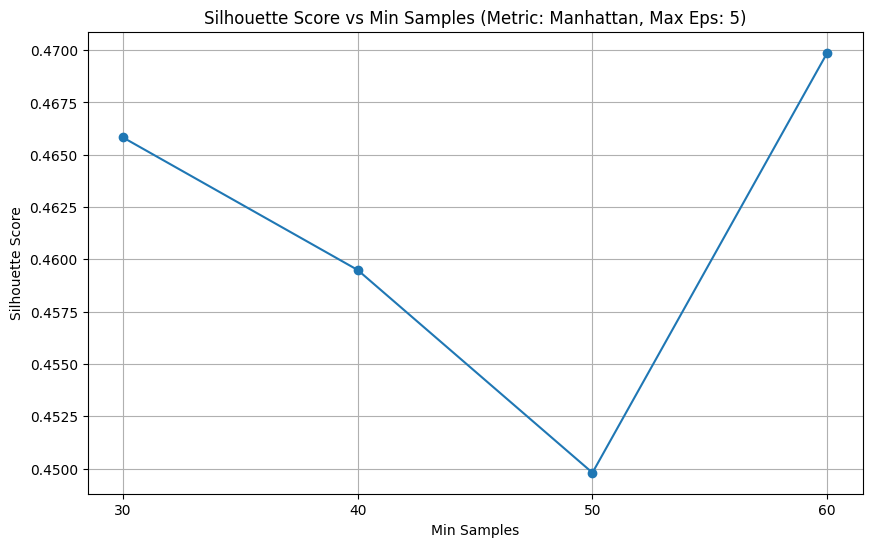

In [115]:
# fix metric to manhattan and eps to 5, plot silhouette score vs min_samples
import matplotlib.pyplot as plt

# Filter results for the specified metric and max_eps
filtered_results = [result for result in results if result['params']['metric'] == 'manhattan' and result['params']['max_eps'] == 5]

# Extract min_samples and silhouette scores
min_samples = [result['params']['min_samples'] for result in filtered_results]
silhouette_scores = [result['silhouette_score'] for result in filtered_results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(min_samples, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Min Samples (Metric: Manhattan, Max Eps: 5)')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.xticks(min_samples)
plt.grid()
plt.show()


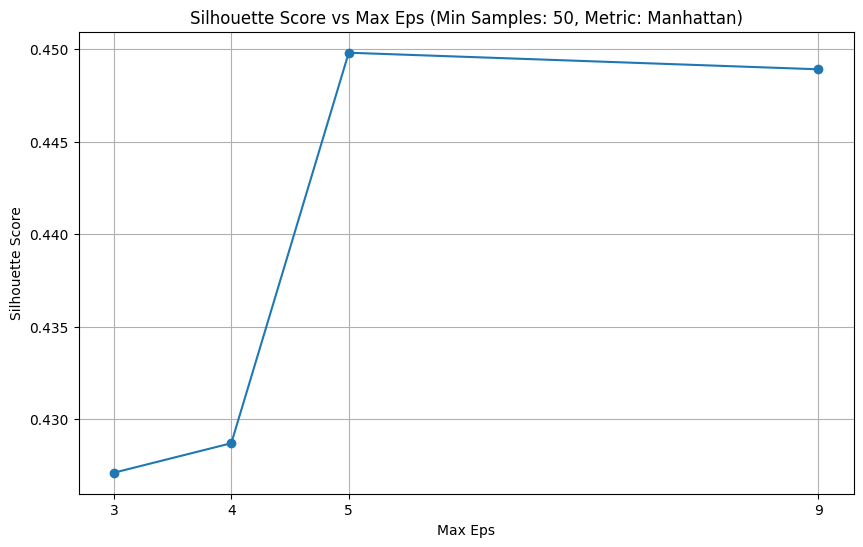

In [122]:
# Filter results for the specified min_samples and metric, and replace np.inf with 99
filtered_results = [
    result for result in results 
    if result['params']['min_samples'] == 50 and result['params']['metric'] == 'manhattan'
]

# Replace np.inf with 99 in max_eps for plotting
for result in filtered_results:
    if result['params']['max_eps'] == np.inf:
        result['params']['max_eps'] = 9

# Extract max_eps and silhouette scores
max_eps = [result['params']['max_eps'] for result in filtered_results]
silhouette_scores = [result['silhouette_score'] for result in filtered_results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_eps, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Max Eps (Min Samples: 50, Metric: Manhattan)')
plt.xlabel('Max Eps')
plt.ylabel('Silhouette Score')
plt.xticks(max_eps)
plt.grid()
plt.show()

Best Parameters for Silhouette Score: {'max_eps': 2, 'metric': 'manhattan', 'min_samples': 4}
Best Silhouette Score: 0.5434478988148148
Number of Clusters for Best Silhouette Score: 17
Best Parameters for Davies-Bouldin Score: {'max_eps': 2, 'metric': 'manhattan', 'min_samples': 2}
Best Davies-Bouldin Score: 0.5823078553974681
Number of Clusters for Best Davies-Bouldin Score: 53
Best Parameters for Calinski-Harabasz Score: {'max_eps': 2, 'metric': 'manhattan', 'min_samples': 4}
Best Calinski-Harabasz Score: 117.08990088508507
Number of Clusters for Best Calinski-Harabasz Score: 17
Silhouette Score: 0.5434
Davies-Bouldin Score: 0.6093
Calinski-Harabasz Score: 117.0899


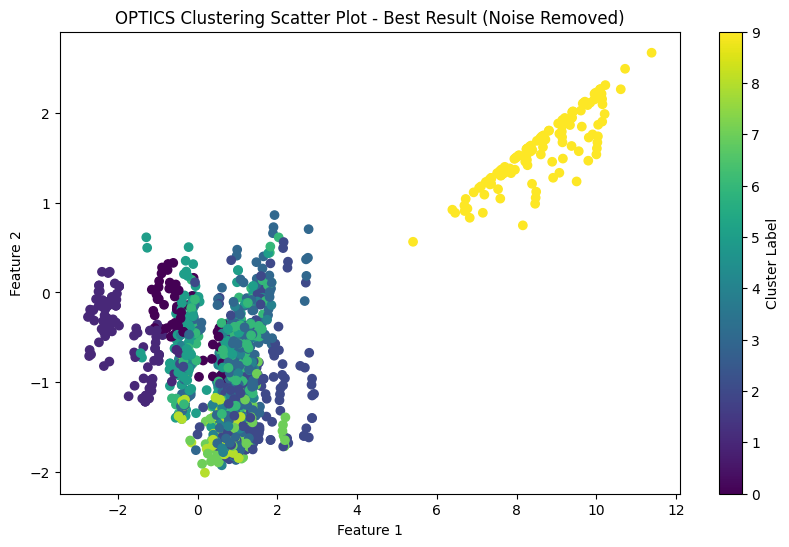

In [114]:
# concat labels to prep.prep_car
X = pd.concat([prep.prep_car, pd.DataFrame(best_result_silhouette['labels'], columns=['cluster_label'])], axis=1)
X = X[X['cluster_label'] != -1]
X_no_label = X.iloc[:, :-1]


best_labels = best_result_silhouette['labels']  # Get the best labels from the best result
plt.figure(figsize=(10, 6))
plt.scatter(X_no_label.iloc[:, 0], X_no_label.iloc[:, 1], c=X['cluster_label'])
plt.title('OPTICS Clustering Scatter Plot - Best Result (Noise Removed)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

OPTICS - customer.csv

In [237]:
hyperparam_grid = {
    "min_samples": [2, 3, 4, 5, 9, 10,11, 12, 13, 14, 15],
    "max_eps": [2, 3, np.inf],
    "metric": ['manhattan'],
}
results = evaluate_optics(prep.prep_customer, hyperparam_grid)


Number of clusters: 53
Number of clusters: 26
Number of clusters: 17
Number of clusters: 10
Number of clusters: 8
Number of clusters: 7
Number of clusters: 5
Number of clusters: 4
Number of clusters: 4
Number of clusters: 3
Number of clusters: 2
Number of clusters: 53
Number of clusters: 26
Number of clusters: 17
Number of clusters: 11
Number of clusters: 8
Number of clusters: 7
Number of clusters: 5
Number of clusters: 3
Number of clusters: 4
Number of clusters: 3
Number of clusters: 2
Number of clusters: 53
Number of clusters: 26
Number of clusters: 17
Number of clusters: 11
Number of clusters: 8
Number of clusters: 7
Number of clusters: 5
Number of clusters: 3
Number of clusters: 4
Number of clusters: 3
Number of clusters: 2


In [242]:

best_result_silhouette, best_result_db, best_result_ch = print_best_results(results, 5)
# print the metrics of the best silhouette param with 4 decimal places
best = best_result_silhouette
print(f"Silhouette Score: {best['silhouette_score']:.4f}")
print(f"Davies-Bouldin Score: {best['davies_bouldin_score']:.4f}")
print(f"Calinski-Harabasz Score: {best['calinski_harabasz_score']:.4f}")


Best Parameters for Silhouette Score: {'max_eps': 2, 'metric': 'manhattan', 'min_samples': 4}
Best Silhouette Score: 0.5434478988148148
Number of Clusters for Best Silhouette Score: 17
Best Parameters for Davies-Bouldin Score: {'max_eps': 2, 'metric': 'manhattan', 'min_samples': 2}
Best Davies-Bouldin Score: 0.5823078553974681
Number of Clusters for Best Davies-Bouldin Score: 53
Best Parameters for Calinski-Harabasz Score: {'max_eps': 2, 'metric': 'manhattan', 'min_samples': 4}
Best Calinski-Harabasz Score: 117.08990088508507
Number of Clusters for Best Calinski-Harabasz Score: 17
Silhouette Score: 0.5434
Davies-Bouldin Score: 0.6093
Calinski-Harabasz Score: 117.0899


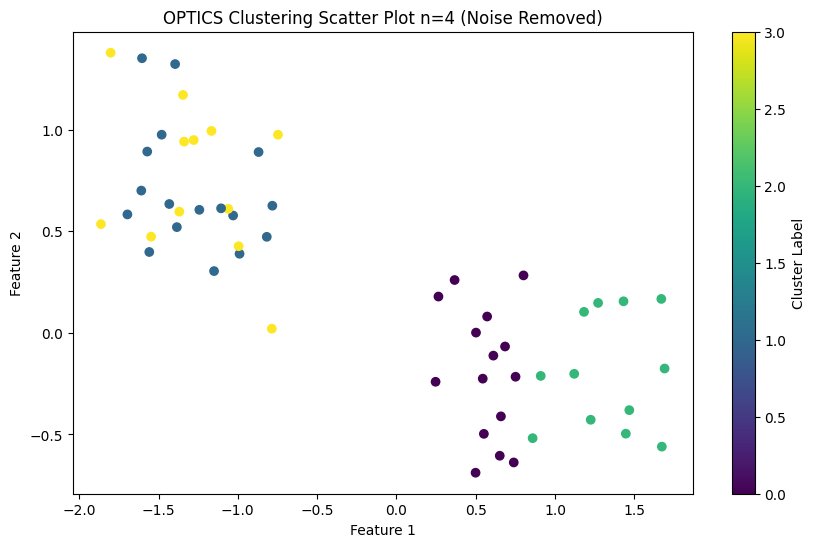

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [240]:
# scatter plot the best silhouette param
X = pd.concat([prep.prep_customer, pd.DataFrame(best_result_silhouette['labels'], columns=['cluster_label'])], axis=1)
X = X[X['cluster_label'] != -1]
X_no_label = X.iloc[:, :-1]

plt.figure(figsize=(10, 6))
plt.scatter(X_no_label.iloc[:, 0], X_no_label.iloc[:, 1], c=X['cluster_label'])
plt.title(f'OPTICS Clustering Scatter Plot n={len(set(best_result_silhouette["labels"])) - 1} (Noise Removed)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()
# histogram of the best silhouette param
plt.figure(figsize=(10, 6))


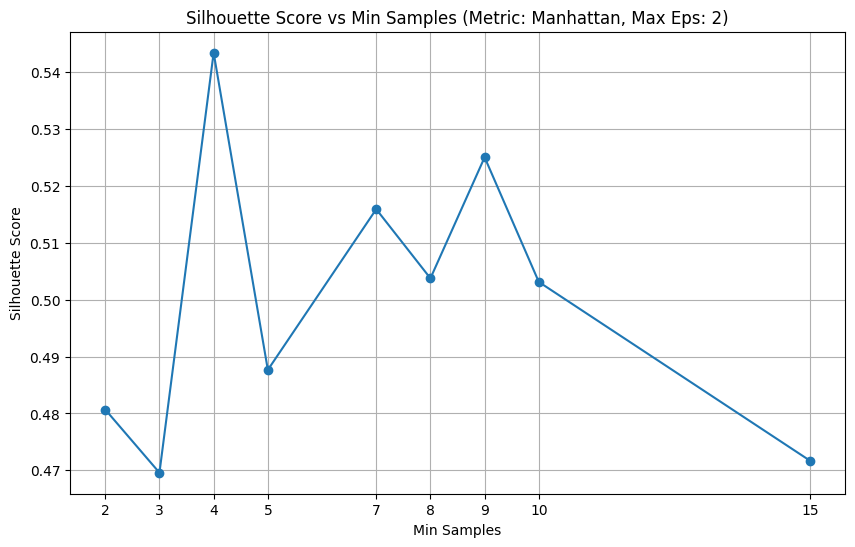

([<matplotlib.axis.XTick at 0x1b129f69490>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

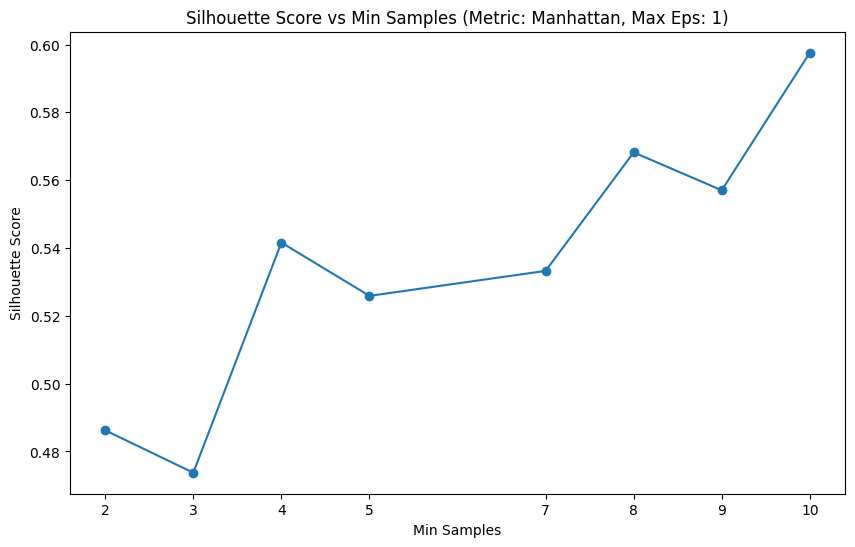

In [162]:
# fix metric to manhattan and eps to 5, plot silhouette score vs min_samples
import matplotlib.pyplot as plt

# Filter results for the specified metric and max_eps
filtered_results = [result for result in results if result['params']['metric'] == 'manhattan' and result['params']['max_eps'] == 2]

# Extract min_samples and silhouette scores
min_samples = [result['params']['min_samples'] for result in filtered_results]
silhouette_scores = [result['silhouette_score'] for result in filtered_results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(min_samples, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Min Samples (Metric: Manhattan, Max Eps: 2)')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.xticks(min_samples)
plt.grid()
plt.show()

filtered_results_2 = [result for result in results if result['params']['metric'] == 'manhattan' and result['params']['max_eps'] == 1]
min_samples_2 = [result['params']['min_samples'] for result in filtered_results_2]
silhouette_scores_2 = [result['silhouette_score'] for result in filtered_results_2]

plt.figure(figsize=(10, 6))
plt.plot(min_samples_2, silhouette_scores_2, marker='o')
plt.title('Silhouette Score vs Min Samples (Metric: Manhattan, Max Eps: 1)')
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.xticks(min_samples_2)